In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
import sklearn
from sklearn import metrics
pd.set_option('display.max_columns', None)

# 1 Exploring the Data

In [209]:
df=pd.read_csv('cookies.csv')

### 1.1 What does the data look like?

In [65]:
df.head()

,sugar to flour ratio,sugar index,bake temp,chill time,calories,density,pH,grams baking soda,bake time,quality,butter type,weight,diameter,mixins,crunch factor,aesthetic appeal
0,0.25,9.5,300,15.0,136.0,0.99367,8.10,0.44,12.1,8,melted,15.2,7,raisins,1.30,3
1,0.23,3.3,520,34.0,113.0,0.99429,8.16,0.48,8.4,7,melted,12.4,7,raisins,1.71,3
2,0.18,1.9,360,33.0,106.0,0.98746,8.21,0.83,14.0,9,melted,9.4,7,"nuts, chocolate",1.78,3
3,0.18,10.5,490,41.0,124.0,0.99630,8.14,0.35,10.5,7,melted,12.2,7,chocolate,1.59,3
4,0.24,2.4,770,6.0,33.0,0.99740,8.09,0.57,9.4,5,cubed,19.8,7,"nuts, oats, chocolate",1.30,3


### 1.2 Do the data types make sense?

**Yes. There are only two object features. All numerical values are under numerical features.**

In [70]:
df.dtypes

sugar to flour ratio    float64
sugar index             float64
bake temp                 int64
chill time              float64
calories                float64
density                 float64
pH                      float64
grams baking soda       float64
bake time               float64
quality                   int64
butter type              object
weight                  float64
diameter                  int64
mixins                   object
crunch factor           float64
aesthetic appeal          int64
dtype: object

### 1.3 Are there any missing values?
**Yes, but these rows account for only around 0.2% of the data and can be removed.**

In [73]:
df.isna().sum()*100/len(df)

sugar to flour ratio    0.000000
sugar index             0.096191
bake temp               0.000000
chill time              0.000000
calories                0.000000
density                 0.000000
pH                      0.000000
grams baking soda       0.000000
bake time               0.192382
quality                 0.000000
butter type             0.000000
weight                  0.000000
diameter                0.000000
mixins                  0.038476
crunch factor           0.000000
aesthetic appeal        0.000000
dtype: float64

### 1.4 Does the data itself make sense?
1. Negative values: `Weight` and `Calories` both contain values below 0.
2. 0 StDev: All instances have the same `Diameter`
3. Temperature: The maximum value for `temperature` does not make sense.

**We will decide what to do with these columns once we look at value distribution in the distribution analysis**

In [72]:
df.describe()

,sugar to flour ratio,sugar index,bake temp,chill time,calories,density,pH,grams baking soda,bake time,quality,weight,diameter,crunch factor,aesthetic appeal
count,5198.000000,5193.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5188.000000,5198.000000,5198.000000,5198.0,5198.000000,5198.000000
mean,0.318049,5.402465,559.638322,30.390246,115.015294,0.995819,8.222020,0.530864,10.494758,7.325125,14.381935,7.0,1.499367,3.000577
std,0.150036,4.668342,353.274062,17.268403,56.506171,0.062193,0.283323,0.150886,1.194584,1.302780,3.023740,0.0,0.289205,0.024019
min,0.000000,0.600000,90.000000,0.000000,-99.000000,0.987110,7.720000,0.220000,8.000000,3.000000,-99.000000,7.0,1.000000,3.000000
25%,0.240000,1.800000,380.000000,17.000000,76.000000,0.992300,8.110000,0.430000,9.500000,7.000000,12.800000,7.0,1.250000,3.000000
50%,0.310000,3.000000,470.000000,29.000000,118.000000,0.994800,8.210000,0.505000,10.300000,8.000000,14.000000,7.0,1.500000,3.000000
75%,0.390000,8.000000,640.000000,41.000000,155.000000,0.996908,8.320000,0.600000,11.300000,8.000000,15.400000,7.0,1.750000,3.000000
max,3.000000,31.600000,6110.000000,146.500000,366.500000,5.000000,25.000000,2.000000,14.900000,11.000000,31.800000,7.0,2.000000,4.000000


### 1.5 Is there Multicollinearity?
**No. No two variables have a correlation above 0.8%**

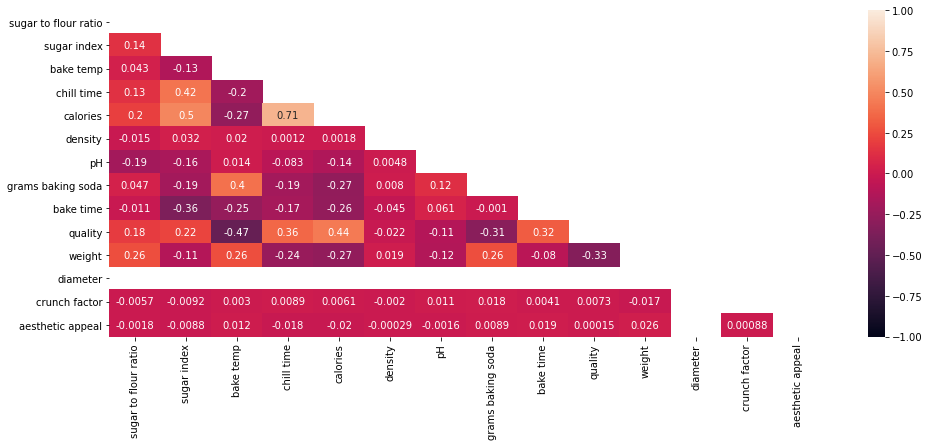

In [76]:
plt.figure(figsize=(16, 6))
mask=np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot=True,vmin=-1,vmax=1,mask=mask);

### 1.6 How is the data in each column distributed?
1. `Sugar to Flour Ratio`: There is a large standard deviation and a high number of outliers, but these are expected, as the proportion of sugar in each type of cookie can vary largely. We can retain this column as is.
2. `Sugar index`: The same occurs here.
3. `Bake Temp`: The baking temperature, which should be in farenheit, varies wildly and ranges from room temeprature to high enough to melt steel. There is clearly an error in the data, and this column needs to be removed.
4. `Chill time`: Wide range, but no value is illogical.
5. `Calories`: Some values are negative, which does not make sense. We assume that any value below six calories, which is the caloric content of the world's healthiest cookie, is an error and we drop the corresponding row.
6. `Density`: 2 instances with values of 3 and 5 far surpass the rest of the values. We thus remove any row with a density greater than 1.1, eliminating these two rows.
7. `pH`: One value far exceeds the rest. We can remove it by setting a threshold of 10 as the max pH.
8. `Grams Baking Soda`: Though the range is wide in relative terms, the difference between the mean and the maximum value is only 1.5 grams of the ingredient. We retain this column
9. `Quality`: The target variable
10. `Weight`: We drop any row with a value less than or equal to 0, as there cannot be a negative weight.
11. `Crunch Factor`: A scaled variable between 1 and 2.
11. `Aesthetic appeal`: A categorical value of either 3 or 4. Nevertheless, there are only three instances with a 4. We drop this column so as to not distort the model.

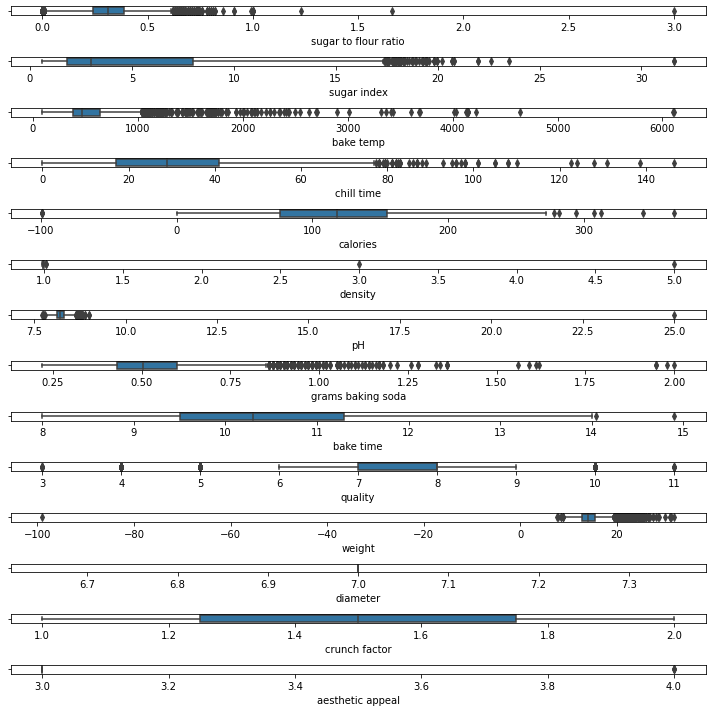

In [79]:
x=df.select_dtypes(include=["int64", "float64"]).copy()
count = 0
fig, ax = plt.subplots(nrows=14, ncols=1,figsize=(10,10))
for param in x.columns:
    sns.boxplot(x=x[param], ax=ax[count])
    count = count + 1
plt.tight_layout()

### 1.7 Can categorical columns be encoded?
1. There are only two categories in `butter type`. The feature can be easily encoded.
2. Though `mixins` has too many unique values, each of these is actually made up of one or more of 5 strings. Each of the 6 mixins can be encoded with a numeric boolean.

In [84]:
df["butter type"].value_counts()

melted    3920
cubed     1278
Name: butter type, dtype: int64

In [85]:
df["mixins"].value_counts()

chocolate                         1893
raisins                           1200
chocolate, oats                    749
nuts, chocolate                    521
nuts,raisins                       333
nuts, oats, chocolate              295
nuts, oats                         107
chocolate, peanut butter            52
raisins, oats                       24
peanut butter                       15
oats                                 4
chocolate, oats, peanut butter       2
peanut butter, raisins               1
Name: mixins, dtype: int64

# 2 Creating a Data Preparation Pipeline

### 2.1  Listing the Changes:
1. Drop null values
2. Remove abnormal outliers
3. Encode categorical columns

### 2.2 Defining the functions

#### 2.2.1 Dropping NaNs

In [210]:
# Drop rows with NaNs
# Since there are very few we drop all the rows
def drop_nans(df):
    X = df.dropna()
    return X

# Convert function to transformer to include in the pipeline
NaNDropper = FunctionTransformer(drop_nans, validate=False)


#### 2.2.2 Removing Abnormal Outliers

In [211]:
def drop_outliers(df):
    # Drop cookies with Cal < 6 
    df = df.drop(df[df['calories'] <= 6].index)

    # Drop degrees because data makes no sense
    df = df.drop('bake temp', axis = 1)

    # Drop density above 1.1
    df = df.drop(df[df['density'] > 1.1].index)

    # Drop pH above 15
    df = df.drop(df[df['pH'] > 10].index)

    # Drop weight below 0 
    X = df.drop(df[df['weight'] < 0].index)
    
    # Drop aesthetic because data makes no sense
    df = df.drop('aesthetic appeal', axis = 1)
    
    return X

# Convert function to transformer to include in the pipeline
OutlierDropper = FunctionTransformer(drop_outliers, validate=False)


#### 2.2.3 Encoding Categorical Columns

In [212]:
def categ_encoder(df):
    # Encode mixins column
    mixin_list = ["nuts","chocolate","raisins","oats","peanut butter"]
    for i in mixin_list:
        df[i]=""

    for i in mixin_list:
        df[i]=df["mixins"].str.contains(i).astype(int)

    X = df.drop(['mixins'], axis = 1)
    
    return X

# Convert function to transformer to include in the pipeline
CategEncoder = FunctionTransformer(categ_encoder, validate=False)

In [213]:
def onehot_encoder(df):
    # One hote encode 
    df['butter type'] =pd.get_dummies(df['butter type'],drop_first=True)
    X = df
    
    return X
    
# Convert function to transformer to include in the pipeline
OneHotEncoder = FunctionTransformer(onehot_encoder, validate=False)

### 2.3 Creating the Pipeline

In [214]:
from sklearn.pipeline import Pipeline

# Create Pipeline

pipeline_one = Pipeline([
    ('nan_dropper', NaNDropper),
    ('outlier_dropper', OutlierDropper),
    ('categ_encoder', CategEncoder),
    ('one_hot_encoder', OneHotEncoder)
])

# 3 Creating the Model

### 3.1 Loading and Fitting the Data

In [215]:
df_actual=pd.read_csv("cookies_validate.csv")

In [216]:
df_train=pipeline_one.fit_transform(df)

In [217]:
df_actual=pipeline_one.fit_transform(df_actual)
df_actual.drop("id",axis="columns",inplace=True)

### 3.2 Splitting the Predictor and Target Variables 

In [236]:
from sklearn.model_selection import train_test_split
y=df_train["quality"]
x=df_train.drop(["quality"],axis="columns")
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2)
x_actual=df_actual.drop(["quality"],axis="columns")
print(y_train.shape,y_test.shape)
x_train.shape,x_test.shape


(4134,) (1034,)


((4134, 18), (1034, 18))

### 3.3 Testing Random Forest Grid with Standard Scaler

In [195]:
sc_x=StandardScaler()
sc_x_train= sc_x.fit_transform(x_train)
sc_x_test= sc_x.fit_transform(x_test)
#random forest with randomized search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              }
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(sc_x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [207]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [238]:
sc_x=StandardScaler()
sc_x_train= sc_x.fit_transform(x_train)
sc_x_test= sc_x.fit_transform(x_test)
sc_x_actual=sc_x.fit_transform(x_actual)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators= 400, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None, bootstrap= False)
rf.fit(sc_x_train, y_train)
test_pred = rf.predict(sc_x_test)
print(" RMSE: "+ str(metrics.mean_squared_error(y_test, test_pred)**.5))
actual_pred=rf.predict(sc_x_actual)


 RMSE: 0.6295695382031035


### 3.4 Final Submission

In [ ]:
from sklearn.model_selection import GridSearchCV
model_pipeline = Pipeline([("scaler", StandardScaler()),
                          ("neigh", KNeighborsRegressor())]) 
param_distribs={
    "scaler__with_std" : [True, False],
    "scaler__with_mean" : [True, False],
    "neigh__n_neighbors": range(20),
    "neigh__weights":["uniform", "distance"],
    "neigh__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "neigh__p":[1,2]
               }
neighbors_search = GridSearchCV(model_pipeline,
                               param_distribs,
                               scoring="neg_mean_squared_error",
                               cv=5,
                               n_jobs=4)
neighbors_search.fit(x_train, y_train)





MSE(y_test, ypred_neigh, squared = False)